<a href="https://colab.research.google.com/github/ShawnLiu119/CapstoneProject_BankingMarketing/blob/main/BankMkting_NN_OrdinalEncoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd 
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix,r2_score
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
import warnings
from imblearn.over_sampling import SMOTE
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
import pandas as pd

In [3]:
url = 'https://raw.githubusercontent.com/ShawnLiu119/CapstoneProject_BankingMarketing/main/rawdata/bank-additional-full.csv'
data = pd.read_csv(url, sep=';')

### Data Transformation - Feature Engineer

In [4]:
data['education'].value_counts()

data_1 = data.copy()
data_1 = data_1[data_1['education'] != 'illiterate']

data_1['edu_new'] = data_1['education'].map({'basic.4y': 'pre_high', 
                                         'basic.9y': 'pre_high',
                                         'basic.6y': 'pre_high',
                                         'university.degree' : 'post_high',
                                         'professional.course':'post_high',
                                         'high.school' : 'high',
                                         'unknown' :'unknown' })

In [5]:
def map_job(row):
    if row['job'] in ['admin.', 'management', 'entrepreneur','self-employed']:
        cat = 'white_collar'
    elif row['job'] in ['housemaid', 'blue-collar', 'technician', 'services']:
        cat = 'blue_collar'
    elif row['job'] in ['student', 'retired', 'unemployed']:
        cat = 'not_working'
    else:
        cat = 'unknown'
    return cat

data_1['job_new'] = data_1.apply(map_job, axis=1)
data_1['job_new'].value_counts(dropna = False)

blue_collar     21017
white_collar    16217
not_working      3606
unknown           330
Name: job_new, dtype: int64

In [6]:
def map_month(row):
    if row['month'] in ['mar', 'apr', 'may']:
        cat = 'spring'
    elif row['month'] in ['jun', 'jul', 'aug']:
        cat = 'summer'
    elif row['month'] in ['sep', 'oct', 'nov']:
        cat = 'fall'
    else:
        cat = 'winter'
    return cat

data_1['season'] = data_1.apply(map_month, axis=1)
data_1['season'].value_counts(dropna = False)

summer    18660
spring    16942
fall       5386
winter      182
Name: season, dtype: int64

In [7]:
data_1.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'edu_new', 'job_new',
       'season'],
      dtype='object')

In [8]:
#This transformed dataframe is based on group discussion on 7/23
# - keep all numerical features as they are
# - consolidate categorical features (education, job, season) and drop originial ones

df_tran_1 = data_1[['age', 'marital', 'default', 'housing', 'loan',
       'contact', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'edu_new', 'job_new', 'season']]

In [9]:
df_tran_1.shape
#this is because we removed illiterate

(41170, 21)

In [10]:
df_tran_1 = df_tran_1.drop(['duration'], axis=1)
df_tran_1.columns

Index(['age', 'marital', 'default', 'housing', 'loan', 'contact',
       'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'y', 'edu_new', 'job_new', 'season'],
      dtype='object')

### Ordinal Encoding For Categorical Features

In [11]:
df_tran_1.head()

,age,marital,default,housing,loan,contact,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,edu_new,job_new,season
0,56,married,no,no,no,telephone,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,pre_high,blue_collar,spring
1,57,married,unknown,no,no,telephone,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,high,blue_collar,spring
2,37,married,no,yes,no,telephone,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,high,blue_collar,spring
3,40,married,no,no,no,telephone,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,pre_high,white_collar,spring
4,56,married,no,no,yes,telephone,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,high,blue_collar,spring


In [12]:
y = df_tran_1['y'].apply(lambda x: 0 if x=='no' else (1 if x=='yes' else -1))
y.value_counts()

0    36534
1     4636
Name: y, dtype: int64

In [13]:
x = df_tran_1.drop('y', axis=1)

In [14]:
x['poutcome'].value_counts()

nonexistent    35547
failure         4251
success         1372
Name: poutcome, dtype: int64

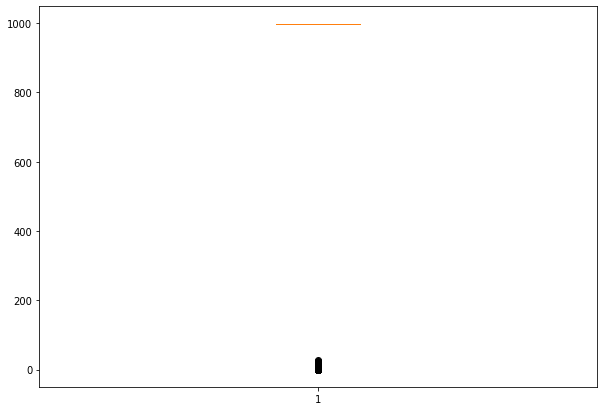

In [15]:
fig = plt.figure(figsize =(10, 7))
plt.boxplot(x['pdays'])
plt.show()

In [16]:
#since the neural network does work very well with sparse matrix, one hot encoding might be suitable, here i will test ordinal encoding

x['housing'] = x['housing'].apply(lambda t: 0 if t =='no' else (1 if t=='yes' else -1))
x['default'] = x['default'].apply(lambda t: 0 if t =='no' else (1 if t=='yes' else -1))

#higher weight is assinged to success result of previous campaign
x['poutcome'] = x['poutcome'].apply(lambda t: 0 if t=='failure' else (2 if t=='success' else 1))

#the further it is from the date when the customer was contacted, the lower the value assigned
x['pdays'] = x['pdays'].apply(lambda t: 0 if t==999 else (3 if t<=10 else (2 if t<= 20 else 1)))

x['loan'] = x['loan'].apply(lambda t: 0 if t=='no' else (1 if t=='yes' else -1))

x['contact'] = x['contact'].apply(lambda t: 0 if t=='telephone' else 1)
x['marital'] = x['marital'].apply(lambda t: 1 if t=='married' else 0)

x['edu_new'] = x['edu_new'].apply(lambda t: 3 if t=='post_high' else (2 if t=='high' else (1 if t=='pre_high' else 0)))
x['season'] = x['edu_new'].apply(lambda t: 3 if t=='summer' else (2 if t=='spring' else (1 if t=='fall' else 0)))
x['job_new'] = x['job_new'].apply(lambda t: 3 if t=='blue_collar' else (2 if t=='white_collar' else (1 if t=='not_working' else 0)))

x.head()

,age,marital,default,housing,loan,contact,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,edu_new,job_new,season
0,56,1,0,0,0,0,mon,1,0,0,1,1.1,93.994,-36.4,4.857,5191.0,1,3,0
1,57,1,-1,0,0,0,mon,1,0,0,1,1.1,93.994,-36.4,4.857,5191.0,2,3,0
2,37,1,0,1,0,0,mon,1,0,0,1,1.1,93.994,-36.4,4.857,5191.0,2,3,0
3,40,1,0,0,0,0,mon,1,0,0,1,1.1,93.994,-36.4,4.857,5191.0,1,2,0
4,56,1,0,0,1,0,mon,1,0,0,1,1.1,93.994,-36.4,4.857,5191.0,2,3,0


In [17]:
x = x.drop(['day_of_week'], axis=1)

### Train-Test Split & Data Normalization

In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_mm = scaler.fit_transform(x)

In [19]:
#here i used stratified sampling approach, since the raw data is not balanced distributed
x_train,x_test,y_train,y_test = train_test_split(x_mm, y, test_size = 0.2, stratify=y, random_state=42)
print(x_train.shape,
      x_test.shape,
      y_train.shape,
      y_test.shape)

(32936, 18) (8234, 18) (32936,) (8234,)


### Balancing the data using SMOTE

https://towardsdatascience.com/all-about-imbalanced-machine-learning-classifiers-60563014d2b3


In [20]:
pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached imbalanced_learn-0.9.1-py3-none-any.whl (199 kB)


In [21]:
import imblearn

smote = SMOTE()

x_s, y_s = smote.fit_resample(x_train, y_train)

print('Original dataset shape', len(x_train))
print('Resampled dataset shape', len(x_s))

Original dataset shape 32936
Resampled dataset shape 58454


### Classification with Neural Network

In [35]:
model = Sequential()
model.add(Flatten(input_shape=( x_s.shape[1],)))
model.add(Dense(units = 64, kernel_initializer = 'he_uniform',activation='relu'))
model.add(Dense(units = 16, kernel_initializer = 'he_uniform',activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units = 1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))

may need to revisit the kernel initialization and tweaking the model
here is the reference:https://www.kaggle.com/code/trolukovich/glorot-vs-he-weight-initialization-experiment/notebook

In [37]:
model.compile(optimizer = 'adamax', loss = 'binary_crossentropy', metrics = ['AUC'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 18)                0         
                                                                 
 dense_3 (Dense)             (None, 64)                1216      
                                                                 
 dense_4 (Dense)             (None, 16)                1040      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,273
Trainable params: 2,273
Non-trainable params: 0
_________________________________________________________________


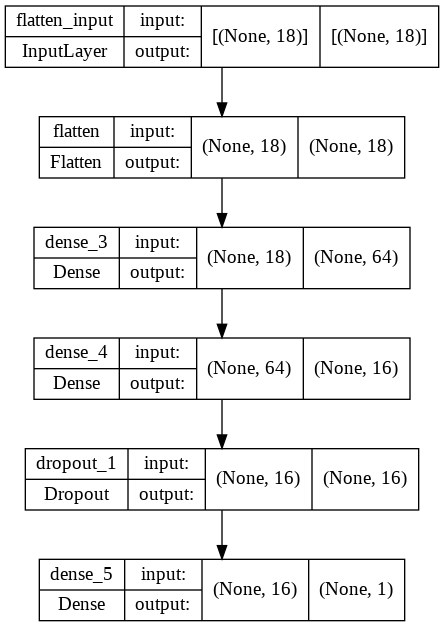

In [38]:
keras.utils.plot_model(model, "CIFAR10.png", show_shapes=True) 

In [39]:
model_history = model.fit(x_s, y_s,validation_split=0.33, batch_size = 32, epochs = 100)

Epoch 1/100
1224/1224 [==============================] - 5s 4ms/step - loss: 0.5946 - auc: 0.7448 - val_loss: 1.1249 - val_auc: 0.0000e+00
Epoch 2/100
1224/1224 [==============================] - 4s 3ms/step - loss: 0.4960 - auc: 0.7633 - val_loss: 1.0621 - val_auc: 0.0000e+00
Epoch 3/100
1224/1224 [==============================] - 4s 3ms/step - loss: 0.4756 - auc: 0.7663 - val_loss: 1.0433 - val_auc: 0.0000e+00
Epoch 4/100
1224/1224 [==============================] - 4s 4ms/step - loss: 0.4697 - auc: 0.7650 - val_loss: 1.1376 - val_auc: 0.0000e+00
Epoch 5/100
1224/1224 [==============================] - 4s 3ms/step - loss: 0.4639 - auc: 0.7695 - val_loss: 1.0695 - val_auc: 0.0000e+00
Epoch 6/100
1224/1224 [==============================] - 4s 3ms/step - loss: 0.4612 - auc: 0.7699 - val_loss: 1.0823 - val_auc: 0.0000e+00
Epoch 7/100
1224/1224 [==============================] - 4s 3ms/step - loss: 0.4593 - auc: 0.7721 - val_loss: 1.0504 - val_auc: 0.0000e+00
Epoch 8/100
1224/1224 [====

In [45]:
from sklearn.metrics import cohen_kappa_score,  average_precision_score


# define functions for model performance evaluation
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print("Kappa- ", cohen_kappa_score(y_test, predictions))
    print("F1- ", f1_score(y_test, predictions))
    print("ROC_AUC_score- ", roc_auc_score(y_test, predictions))
    print("PR AUC- ", average_precision_score(y_test, predictions))


def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_curve(y_test, predictions):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))
    fig.tight_layout()
    fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    ax1.set_title('Receiver Operating Characteristic')
    ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    ax1.legend(loc = 'lower right')
    ax1.plot([0, 1], [0, 1],'r--')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')

    lr_precision, lr_recall, _ = metrics.precision_recall_curve(y_test, predictions)
    ax2.set_title('Precision-Recall AUC Curve')
    ax2.plot(lr_recall, lr_precision, marker='.')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])

    plt.show()

In [40]:
preds = model.predict(x_test)
preds=np.argmax(preds, axis=1)
print('shape of preds: ', preds.shape)

shape of preds:  (8234,)


In [41]:
print_validation_report(y_test, preds)

Classification Report
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      7307
           1       0.00      0.00      0.00       927

    accuracy                           0.89      8234
   macro avg       0.44      0.50      0.47      8234
weighted avg       0.79      0.89      0.83      8234

Accuracy Score: 0.8874180228321593
Kappa-  0.0
F1-  0.0
ROC_AUC_score-  0.5
PR AUC-  0.11258197716784066


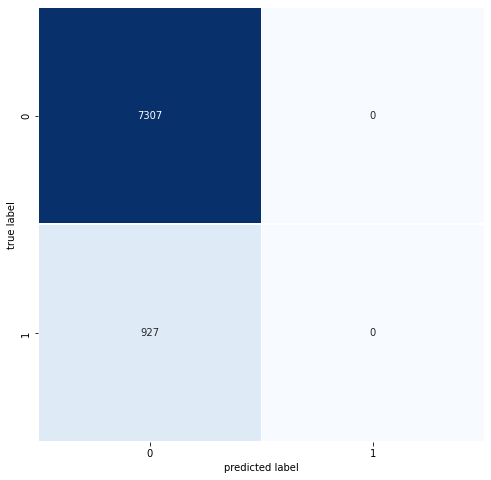

In [46]:
plot_confusion_matrix(y_test, preds)

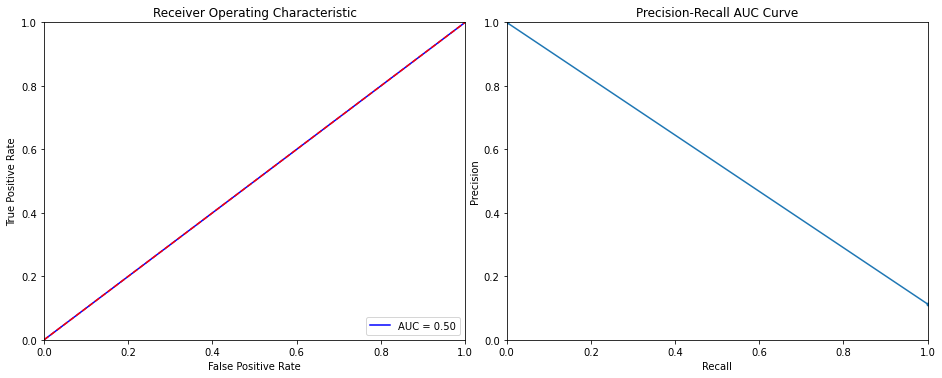

In [48]:
plot_curve(y_test, preds)

In [47]:
loss, accuracy = model.evaluate(x_test, y_test)

258/258 [==============================] - 0s 2ms/step - loss: 0.3293 - auc: 0.7934


### Use sklearn MLPClassifier for comparison purpose

In [50]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(50,200,50), max_iter=300, activation='relu', solver='adam', random_state=1)
mlp.fit(x_s, y_s)

MLPClassifier(hidden_layer_sizes=(50, 200, 50), max_iter=300, random_state=1)

In [52]:
print('Accuracy')
print(mlp.score(x_test, y_test))

Accuracy
0.7710711683264513


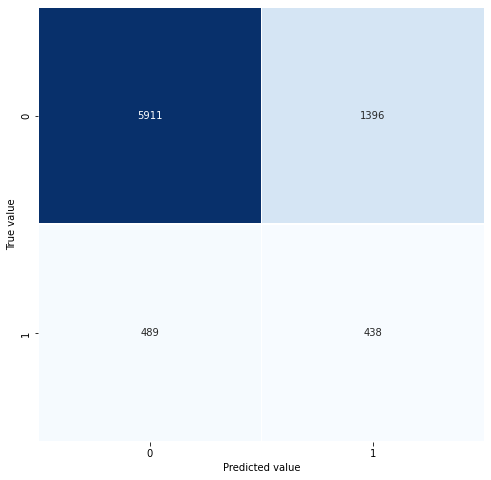

In [53]:
predict = mlp.predict(x_test)
confusion_matrix = confusion_matrix(y_test, predict)
fig, ax = plt.subplots(figsize=(8,8))
ax =  sns.heatmap(confusion_matrix, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
plt.ylabel('True value')
plt.xlabel('Predicted value')
plt.show()